In [ ]:
!pip install imutils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Covid19-dataset

/content/drive/MyDrive/Covid19-dataset


In [ ]:
import os
import argparse
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input

plt.style.use('ggplot')

In [ ]:
imagePathsTrain = list(paths.list_images("/content/drive/MyDrive/Covid19-dataset/train"))
trainX = []
trainY = []

for imagePath in imagePathsTrain:

	label = imagePath.split(os.path.sep)[-2]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	trainX.append(image)
	trainY.append(label)

trainX = np.array(trainX, dtype="float32")
trainY = np.array(trainY)

lb = LabelEncoder()
trainY = lb.fit_transform(trainY)
trainY = to_categorical(trainY)

In [ ]:
imagePathsTest = list(paths.list_images("/content/drive/MyDrive/Covid19-dataset/test"))
testX = []
testY = []

for imagePath in imagePathsTest:

	label = imagePath.split(os.path.sep)[-2]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	testX.append(image)
	testY.append(label)

testX = np.array(testX, dtype="float32")
testY = np.array(testY)

lb = LabelEncoder()
testY = lb.fit_transform(testY)
testY = to_categorical(testY)


In [ ]:
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.15, random_state=42, stratify=trainY)

In [ ]:
print("SHAPE OF TRAIN FEATURES: "+str(trainX.shape))
print("SHAPE OF TRAIN LABELS: "+str(trainY.shape))
print("SHAPE OF VALIDATION FEATURES: "+str(valX.shape))
print("SHAPE OF VALIDATION LABELS: "+str(valY.shape))
print("SHAPE OF TEST FEATURES: "+str(testX.shape))
print("SHAPE OF TEST LABELS: "+str(testY.shape))

SHAPE OF TRAIN FEATURES: (94, 224, 224, 3)
SHAPE OF TRAIN LABELS: (94, 3)
SHAPE OF VALIDATION FEATURES: (17, 224, 224, 3)
SHAPE OF VALIDATION LABELS: (17, 3)
SHAPE OF TEST FEATURES: (73, 224, 224, 3)
SHAPE OF TEST LABELS: (73, 3)


In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [ ]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = True

opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

94781440/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
HR = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(valX, valY),
	validation_steps=len(valX) // BS,
	epochs=EPOCHS)

Epoch 1/20
2/2 [==============================] - 43s 21s/step - loss: 0.7508 - accuracy: 0.6250
Epoch 2/20
2/2 [==============================] - 43s 22s/step - loss: 0.6191 - accuracy: 0.8871
Epoch 3/20
2/2 [==============================] - 43s 21s/step - loss: 0.5727 - accuracy: 0.7656
Epoch 4/20
2/2 [==============================] - 43s 21s/step - loss: 0.4823 - accuracy: 0.8281
Epoch 5/20
2/2 [==============================] - 42s 22s/step - loss: 0.4669 - accuracy: 0.8226
Epoch 6/20
2/2 [==============================] - 42s 20s/step - loss: 0.4415 - accuracy: 0.7742
Epoch 7/20
2/2 [==============================] - 43s 21s/step - loss: 0.2809 - accuracy: 0.9219
Epoch 8/20
2/2 [==============================] - 42s 22s/step - loss: 0.3254 - accuracy: 0.8710
Epoch 9/20
2/2 [==============================] - 44s 22s/step - loss: 0.2456 - accuracy: 0.9375
Epoch 10/20
2/2 [==============================] - 43s 22s/step - loss: 0.2190 - accuracy: 0.9375
Epoch 11/20
2/2 [============

KeyError: ignored

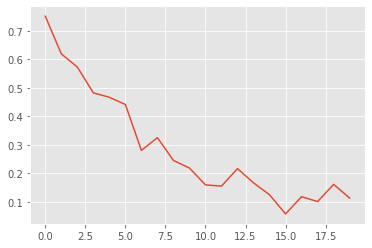

In [ ]:
N = EPOCHS

plt.figure()
plt.plot(np.arange(0, N), HR.history["loss"], label="Training Loss")
plt.plot(np.arange(0, N), HR.history["val_loss"], label="Validation Loss")
plt.title("Training Loss and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("LossPlotWMF.png")

KeyError: ignored

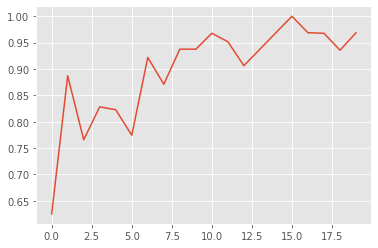

In [ ]:
plt.figure()
plt.plot(np.arange(0, N), HR.history["accuracy"], label="Training Accuracy")
plt.plot(np.arange(0, N), HR.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training Accuracy and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("AccuracyPlotWMF.png")